<a href="https://colab.research.google.com/github/ramos453/Data_Analyst_Jobs_Analysis/blob/main/Data_Analyst_Jobs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this project I decided to investigate data analyst job postings. This dataset is provided by Kaggle. It includes over 2000 job postings from Glassdoor, a popular job search platform. As I'm looking for a position as a data analyst, I'm hoping this project might aid my thought process when applying to jobs. The dataset is about ~7MB and is attached in the repository. I hope you enjoy the project.

I will break down the research questions below which I hope to answer through my analysis.

1) What factors influence salary the most
- Do larger companies offer larger salaries?
- Does the industry/sector heavily influence salary range?
- Does position location affect salary?  

2) What factors might influence rating the most
- Glassdoor is known for their employee ratings that help future candidates assess companies in terms of work environment and so on.
- Are salary and rating correlated?
- Is location, industry, etc... predictive of employee rating?


The first step is to load the necessary packages.

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import spacy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
from scipy import stats
from statsmodels.formula.api import ols

The following code cell reads the data and prints the column names.
Below is a breakdown of each column and its meaning.

Job Title: String specifying Job Title

Salary Estimate: String containing a range of Salaries (300,000 - 500,000)

Job Description: String describing the position and responsibilities

Rating: Float, Glassdoor generated rating based on past employee reviews

Company Name: String, Company Name

Headquarters: String, City name and State name

Size: String, number of employees

Founded: Integer, year founded

Type of ownership: String, ownership structure

Industry: String, Industry

Sector: String, Sector

Revenue: String, Revenue per year

Competitors: String, Name of competitors (-1, if no competitors)

Easy Apply: String, Glassdoor easy apply function (-1, if Easy Apply not possible)


In [2]:
#Reading the data
data = pd.read_csv("DataAnalyst.csv")

In [3]:
#Intial View of data
pd.set_option('display.max_colwidth', 50)
data.head(5)

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


The following cell looks for na values within the dataframe.

In [4]:
rows_with_na = data[data.isnull().any(axis=1)]
rows_with_na
# one rows with na's to be dropped

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
1860,1860,Data Analyst,$53K-$99K (Glassdoor est.),"Kindred at Home, part of the Kindred at Home f...",-1.0,NaN,"Mooresville, NC",-1,-1,-1,-1,-1,-1,-1,-1,-1


In [5]:
# Cleansing data from unknown values
data = data.dropna()

The first step in preparing the data is to handle missing values commonly represented by 'Nan'. However, in this dataset unknown values are also represented by '-1' or 'Unknown'. The following cell counts the number of rows that contain a missing value.

In [6]:
missing_value_counts = {}
for column in data.columns:
    missing_count = data[column].isin(['-1', 'Unknown', -1.0, -1., -1]).sum()
    missing_value_counts[column] = missing_count

missing_value_series = pd.Series(missing_value_counts)
print("Missing value counts per column:")
print(missing_value_series)

Missing value counts per column:
Unnamed: 0              0
Job Title               0
Salary Estimate         1
Job Description         0
Rating                271
Company Name            0
Location                0
Headquarters          171
Size                  204
Founded               659
Type of ownership     178
Industry              352
Sector                352
Revenue               162
Competitors          1731
Easy Apply           2172
dtype: int64


The output above indicates that many features contain substantial numbers of unknown values. To preserve as much data as possible for analyzing relationships between individual features and the response variables ('Salary Estimate' and 'Rating'), only rows with missing values for the feature under analysis will be dropped. This approach ensures a more precise representation of each feature's influence on the response variables.

After seeing an initial view of the data, some data cleaning is necessary to transform the data. It is important to perform exploratory data analysis on each column to better understand the data.  

The following code cell drops the "Unamed" column since a default index is provided already.

In [7]:
pd.set_option('display.max_colwidth', None)
data = data.drop('Unnamed: 0', axis =1)

The goal of this next subsection is to inspect individual columns and apply logical transfromations as well as to discover relationships between the variables.

# Target Columns (Salary Estimate and Rating)

# Salary Estimate

The following code cell looks into the "Salary Estimate" column.

In [8]:
data['Salary Estimate'].unique()[0:10]

array(['$37K-$66K (Glassdoor est.)', '$46K-$87K (Glassdoor est.)',
       '$51K-$88K (Glassdoor est.)', '$51K-$87K (Glassdoor est.)',
       '$59K-$85K (Glassdoor est.)', '$43K-$76K (Glassdoor est.)',
       '$60K-$110K (Glassdoor est.)', '$41K-$78K (Glassdoor est.)',
       '$45K-$88K (Glassdoor est.)', '$73K-$127K (Glassdoor est.)'],
      dtype=object)

To prepare this data, two columns can replace the current column. These two new columns will hold the lower salary expectation and higher salary expectation as a float. The two new columns will represent the range of expected salaries for the position in thousands. In addition, a new column will hold the average salary. The following code cell performs this transformation.

In [9]:
data = data[data['Salary Estimate'] != '-1'] # remove unknown salary estimates, only one row
data['Low_Salary'] = data['Salary Estimate'].str.extract(r'\$(\d+)K-\$\d+K').astype(float)
data['High_Salary'] = data['Salary Estimate'].str.extract(r'\$\d+K-\$(\d+)K').astype(float)
data = data.drop('Salary Estimate', axis=1)
data['Average_Salary'] = (data['Low_Salary'] + data['High_Salary']) / 2

In [10]:
data[['High_Salary', 'Low_Salary', 'Average_Salary']].head(5)


,High_Salary,Low_Salary,Average_Salary
0,66.0,37.0,51.5
1,66.0,37.0,51.5
2,66.0,37.0,51.5
3,66.0,37.0,51.5
4,66.0,37.0,51.5


If you decide to run the cell above more than once, please remember to restart the kernel and re-run all as the dropping of columns will cause an error when re-running.

# Rating

The following cell looks at the 'Rating' column.

In [11]:
data['Rating'].unique()

array([ 3.2,  3.8,  3.4,  4.1,  3.9,  4.4,  3.7,  4. , -1. ,  3. ,  3.6,
        4.9,  3.3,  3.5,  5. ,  4.8,  4.7,  4.6,  2.9,  1. ,  3.1,  4.5,
        2.3,  4.2,  2.8,  4.3,  2.7,  2.5,  2.6,  2.4,  2. ,  2.1,  1.7,
        2.2,  1.8,  1.6,  1.9])

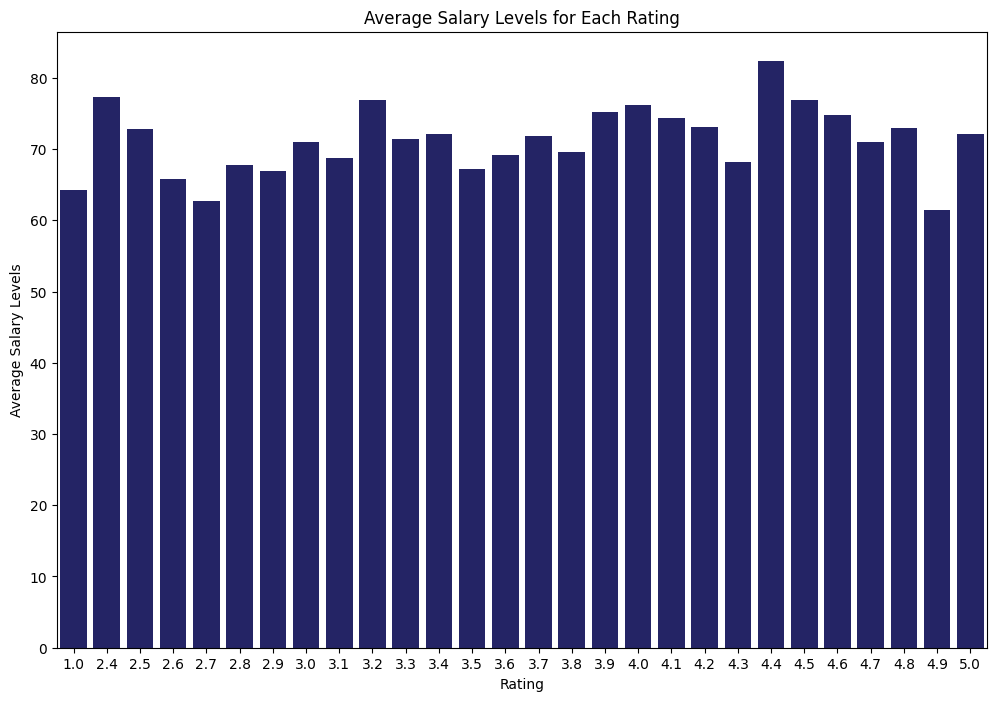

In [12]:
data_rating = data[data['Rating'] != -1.0].copy()
# Count the number of observations for each rating
rating_counts = data_rating['Rating'].value_counts()
# Exclude ratings with fewer than 10 observations
rating_counts = rating_counts[rating_counts >= 10]
data_rating = data_rating[data_rating['Rating'].isin(rating_counts.index)]
plt.figure(figsize=(12, 8))
sb.barplot(x='Rating', y='Average_Salary', data=data_rating, color="midnightblue", errorbar=None)
plt.xlabel('Rating')
plt.ylabel('Average Salary Levels')
plt.title('Average Salary Levels for Each Rating')


plt.show()

The chart above suggests no correlation between ‘Rating’ and ‘Average_Salary’.

# Features

# **Job** **Title**

The following code cell investigates the "Job Title" column to see if there are any beneficial transformations to be applied.

In [13]:
len(data['Job Title'].unique())
for i in data['Job Title'].head(5).unique():
  print(i)

Data Analyst, Center on Immigration and Justice (CIJ)
Quality Data Analyst
Senior Data Analyst, Insights & Analytics Team [Customer Operations]
Data Analyst
Reporting Data Analyst


Length of job title could indicate higher paying positions as they may require more specialized skills. The following cell calculates the length of the job titles by character.

In [14]:
data['job_title_length'] = data['Job Title'].apply(len)

In [15]:
data['job_title_length'].unique()

array([ 53,  20,  68,  12,  22,  28,  29,  19,  32,  27,  21,  23,  30,
        36,  24,  37,  52,  57,  43,  15,  31,  46,  26,  14,  42,  34,
        25,  38,  63,  66,  16,  33,  35,  41,  59,  51,  49,  47,  56,
        45,  44,  54,  39,  17,  62,  78,  48,  50,  79,  55,  18, 106,
        65, 115,  58,  40,  69,  61, 100,  73,  86,  83,  70,  88,  60,
        81,  13,  90,  76, 118,  93,  99,  67,  80,  64,  95,  75,  71,
       114,  72, 107,  97])

The job titles can be grouped into buckets reflecting their length.

In [16]:
def bin_length(length):
    return (length // 10) * 10

data['Length_Group'] = data['job_title_length'].apply(bin_length)
job_title_length_data = data[['Length_Group', 'Average_Salary', 'Rating']].copy()
job_title_length_data_rating = job_title_length_data[job_title_length_data['Rating'] != -1.0].copy()

The following cell performs a one-way ANOVA test to determine whether job title length affects salary.

In [17]:
model_salary = ols('Average_Salary ~ C(Length_Group)', data=job_title_length_data).fit()
anova_salary = sm.stats.anova_lm(model_salary, typ=2)
# Output the ANOVA results
print("ANOVA for Average Salary by Length Group")
print(anova_salary)

ANOVA for Average Salary by Length Group
                       sum_sq      df         F    PR(>F)
C(Length_Group)  5.316135e+03    10.0  0.953824  0.482193
Residual         1.248464e+06  2240.0       NaN       NaN


The ANOVA tests do not provide evidence to conclude that job title length affects salary. The following cell plots the residuals to check for normaility which is a required assumption when performing an ANOVA test.

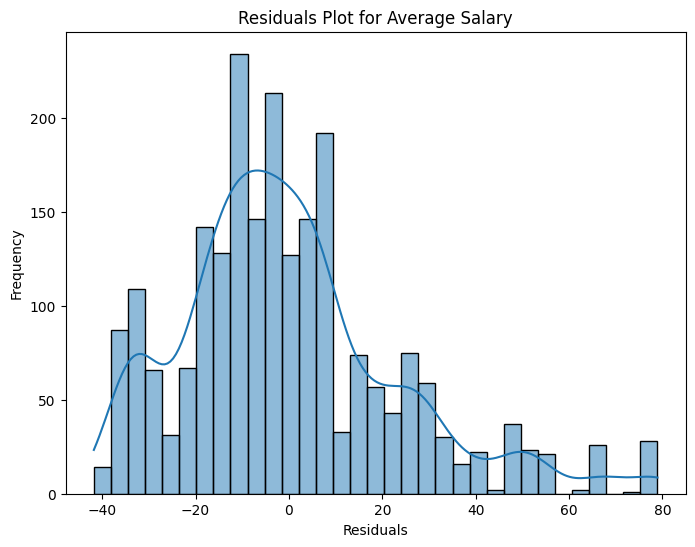

In [18]:
residuals = model_salary.resid  # Replace with your actual residuals
# Residual plot for 'Average_Salary'
plt.figure(figsize=(8, 6))
sb.histplot(residuals, kde=True)
plt.title('Residuals Plot for Average Salary')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

The graph above reflects normality within the residuals with a slight right skew.

# Job Description

The next cell looks into the "Job Description" column. Job descriptions that include advanced skills might be indicative of higher paying jobs. Similarly, job descriptions that include positive work environment vocabulary might be indicative of higher employee ratings.

In [19]:
data['Job Description'] = data['Job Description'].str.lower()
data['Job Description'].head(1)

0    are you eager to roll up your sleeves and harness data to drive policy change? do you enjoy sifting through complex datasets to illuminate trends and insights? do you see yourself working for a values-driven organization with a vision to tackle the most pressing injustices of our day?\n\nwe are looking to hire a bright, hard-working, and creative individual with strong data management skills and a demonstrated commitment to immigrant's rights. the data analyst will assist with analysis and reporting needs for veras center on immigration and justice (cij), working across its current projects and future vera initiatives.\n\nwho we are:\n\nfounded in 1961, the vera institute is an independent, non-partisan, nonprofit organization that combines expertise in research, technical assistance, and demonstration projects to assist leaders in government and civil society examine justice policy and practice, and improve the systems people rely on for justice and safety.\nwe study problems tha

As one can imagine, quantifying job descriptions could prove difficult. To quanitify job descriptions a bag of words approach can be used. Counting the amount of key words in each job description can provide insights between job description and salary expectations. The following code cell contains a bag of words which may help identify higher paying jobs. These words represent some of the top skills recommended by consulting firms for individuals looking to break into the data analytics field.

In [20]:
bag_of_words = [
    'advanced', 'models', 'machine learning',
    'data science', 'artificial intelligence', 'big data',
    'deep learning', 'cloud', 'java',
    'intelligence', 'data mining', 'python',
    'r programming', 'sql', 'hadoop', 'master', 'phd', 'bachelors',
    'degree', 'mathematics', 'statistic', 'quantitive', 'research',
    'snowflake', 'database', 'manage', 'visualization', 'tableau',
    'power bi', 'computer science', 'c++', 'c#'
]

The following code cell counts the number of keywords found in each job description.

In [21]:
# Column for keyword count
data['Job Description Keyword Count'] = data['Job Description'].apply(
    lambda description: sum(word in description for word in bag_of_words)
)

This code cell finds the job description with the highest number of keywords.

In [22]:
data.loc[data['Job Description Keyword Count'].idxmax()]

Job Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

The following code cell plots the number of keywords found in job descriptions to the average salary expectations.

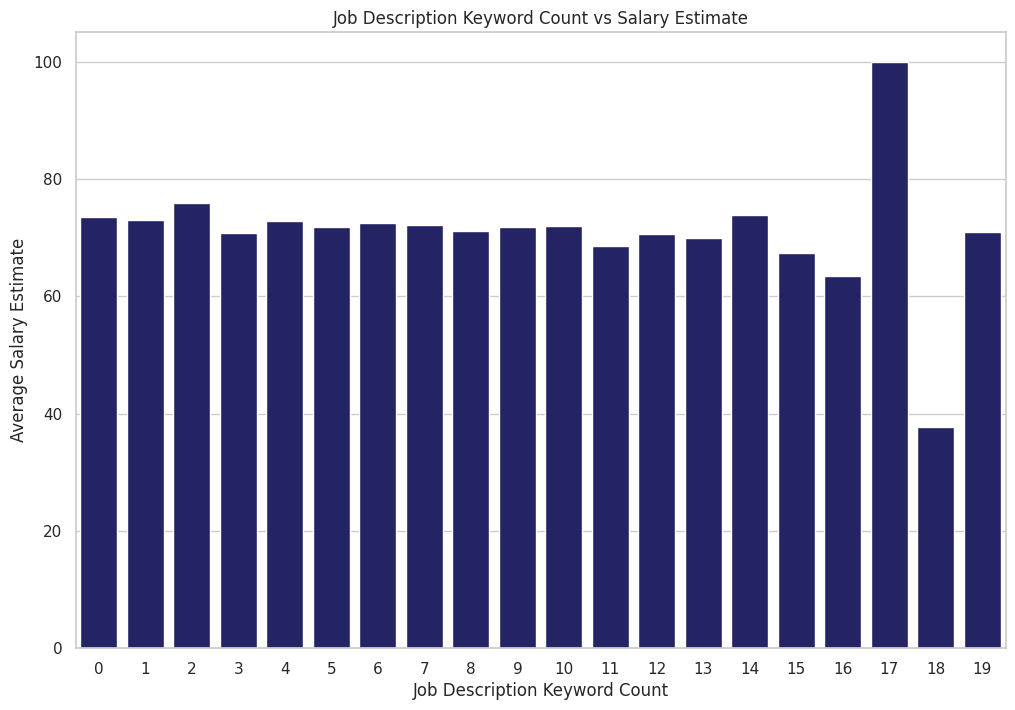

In [23]:
data_description = data[data['Job Description'] != '-1']
sb.set(style="whitegrid")
keyword_mean = data_description.groupby('Job Description Keyword Count')['Average_Salary'].mean().reset_index(name='Mean')
plt.figure(figsize=(12, 8))
sb.barplot(x='Job Description Keyword Count', y='Mean', data=keyword_mean, color = "midnightblue")
plt.xlabel('Job Description Keyword Count')
plt.ylabel('Average Salary Estimate')
plt.title('Job Description Keyword Count vs Salary Estimate')
plt.show()


This chart suggest that the number of keywords found has no clear correlation with salary expectations.

The following cell creates a bag of words representing some positive work environemt vocabulary that might be indicative of higher ratings.

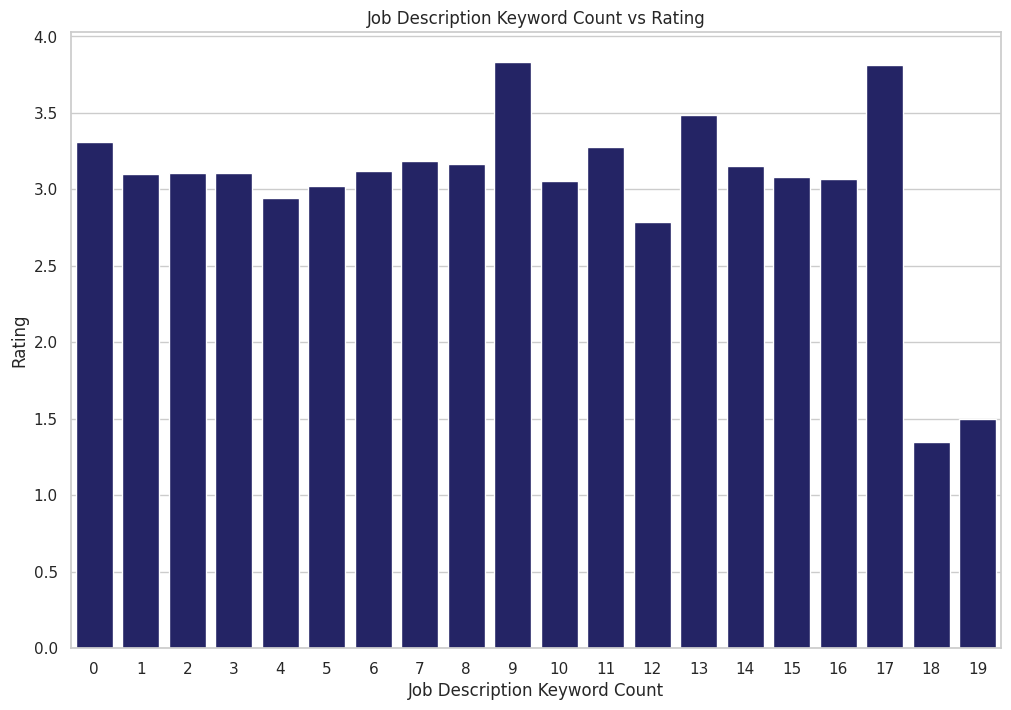

In [24]:
bag_of_words_2 = [
    'diverse', 'inclusive', 'hybrid', 'passionate',
    'friendly', 'supportive', 'collaborative', 'flexible',
    'innovative', 'empathetic', 'motivating', 'inspirational',
    'teamwork', 'respectful', 'equitable', 'engaging',
    'open-minded', 'welcoming', 'nurturing', 'growth-oriented',
    'positive', 'healthy', 'balanced', 'trustworthy',
    'empowering', 'dynamic', 'compassionate', 'transparent',
    'encouraging', 'rewarding', 'adaptive', 'balanced'
]

# Column for keyword count
data['Job Description Keyword Count'] = data['Job Description'].apply(
    lambda description: sum(word in description for word in bag_of_words)
)

sb.set(style="whitegrid")
keyword_mean = data_description.groupby('Job Description Keyword Count')['Rating'].mean().reset_index(name='Mean')
plt.figure(figsize=(12, 8))
sb.barplot(x='Job Description Keyword Count', y='Mean', data=keyword_mean, color = "midnightblue")
plt.xlabel('Job Description Keyword Count')
plt.ylabel('Rating')
plt.title('Job Description Keyword Count vs Rating')
plt.show()

Similarly, there is no indication that keywords related to a positive work enironment have a correlation to higher ratings.

# Location

The following cell splits "Location" into "Location_City" and "Location_State", therefore allowing for a more general understanding of state vs expected salary correlation.

In [25]:
data['Location'] = data['Location'].str.lower().str.replace(',', '')
data[['Location_City', 'Location_State']] = data['Location'].str.extract(r'(.+?)\s*([a-zA-Z]{2})$')
data['Location_City'] = data['Location_City'].str.strip()
data[['Location', 'Location_City', 'Location_State']].head()


,Location,Location_City,Location_State
0,new york ny,new york,ny
1,new york ny,new york,ny
2,new york ny,new york,ny
3,new york ny,new york,ny
4,new york ny,new york,ny


From the two charts below it is clear that states have different average salaries. Therefore, the "Location" of a job is likely an important predictor of expected salary.

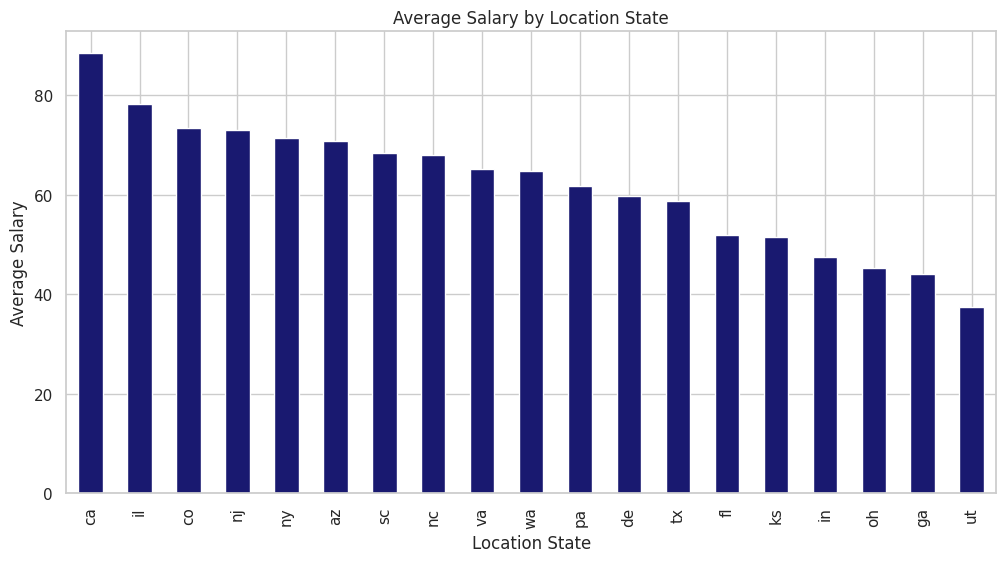

In [26]:
average_salary_by_state = data.groupby('Location_State')['Average_Salary'].mean()
average_salary_by_state = average_salary_by_state.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
average_salary_by_state.plot(kind='bar', color='midnightblue')
plt.title('Average Salary by Location State')
plt.xlabel('Location State')
plt.ylabel('Average Salary')
plt.show()

Contextually, state might play a role in employee satisfaction. The following cell explores if there is any correlation between state and employee ratings.

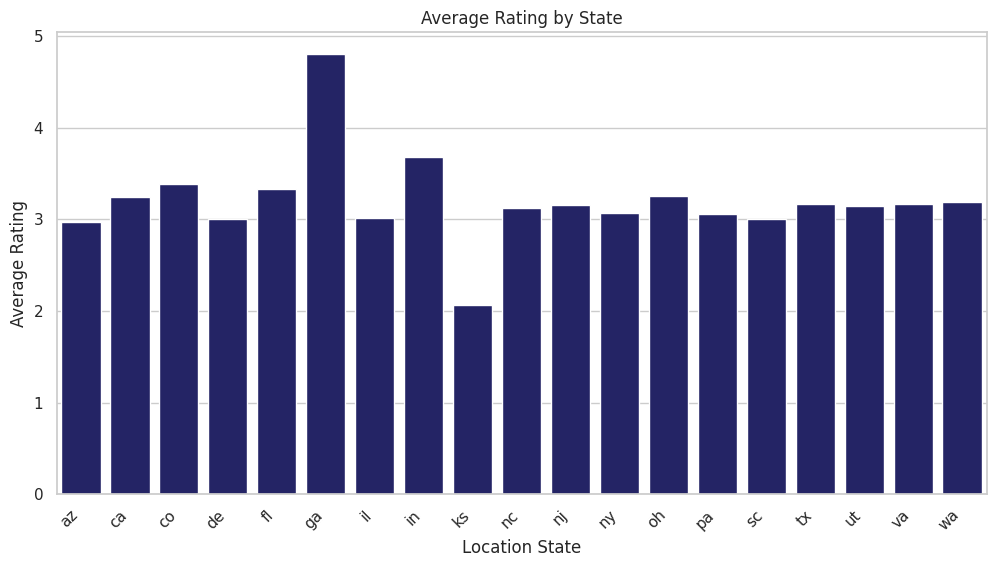

In [27]:
df_rating = data[data['Job Description'] != '-1'].copy()
average_rating_by_state = df_rating.groupby('Location_State')['Rating'].mean()
plt.figure(figsize=(12, 6))
sb.barplot(x=average_rating_by_state.index, y=average_rating_by_state, color='midnightblue')
plt.title('Average Rating by State')
plt.xlabel('Location State')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.show()

It seems as if all states have similar average ratings except for KS and GA. However, the following cell provides a table of the states and their respective counts. GA and KS only have 3 ratings each and therefore a conclusion whether these states have higher or lower ratings cannot be made.

In [28]:
state_counts = data['Location_State'].value_counts().reset_index()
state_counts.columns = ['Location_State', 'Count']
state_counts

,Location_State,Count
0,ca,626
1,tx,394
2,ny,345
3,il,164
4,pa,114
5,az,97
6,co,96
7,nc,89
8,nj,86
9,wa,53


In order to prepare the data for futher analysis, job postings from Georgia, South Carolina and Kansas will be dropped because their sample size is too small to be indicative of true underlying trends.

In [29]:
data = data[~data['Location_State'].isin(['ga', 'ks', 'sc'])]

# Headquarters


The following cell looks at any sort of interaction between headquarter location and job location by state.

In [30]:
data_copy = data.copy()
data_copy['Headquarters'] = data_copy['Headquarters'].str.lower().str.replace(',', '')
data_copy[['Headquarters_City', 'Headquarters_State']] = data_copy['Headquarters'].str.extract(r'(.+?)\s*([a-zA-Z]{2})$')
data_copy['Headquarters_City'] = data_copy['Headquarters_City'].str.strip()
data_copy['HQ_&_Location'] = data_copy['Headquarters_State'] == data_copy['Location_State']


The two charts below suggest that, the location of the job being in the same state as the company's headquarters has no correlation to higher or lower salaries.

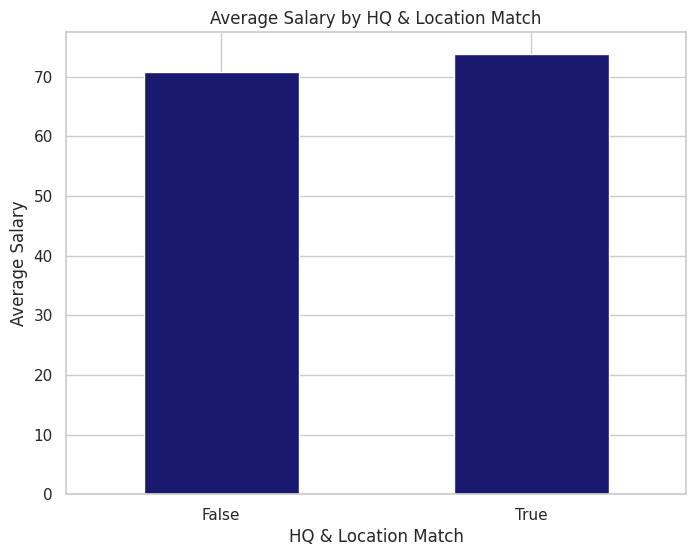

In [31]:
data_hq = data_copy[data_copy['Headquarters'] != '-1'].copy()
average_salary_by_hq_location = data_hq.groupby('HQ_&_Location')['Average_Salary'].mean()
plt.figure(figsize=(8, 6))
average_salary_by_hq_location.plot(kind='bar', color= 'midnightblue')
plt.title('Average Salary by HQ & Location Match')
plt.xlabel('HQ & Location Match')
plt.ylabel('Average Salary')
plt.xticks(rotation=0)
plt.show()

Since there was no clear correlation between location and ratings, any conclusion drawn from the interaction of headquarter location and job location would be irrelavant in terms of rating.

# Company Size

The following cell looks at company size.


In [32]:
data['Size'].unique()

array(['201 to 500 employees', '10000+ employees',
       '1001 to 5000 employees', '501 to 1000 employees',
       '5001 to 10000 employees', '1 to 50 employees',
       '51 to 200 employees', 'Unknown', '-1'], dtype=object)

In [33]:
size_data = data[['Size', 'Average_Salary','Rating']].copy()
size_data = size_data[~size_data['Size'].isin(['-1', 'Unknown'])]
size_data_rating = size_data[size_data['Rating'] != -1.0].copy()
size_data

,Size,Average_Salary,Rating
0,201 to 500 employees,51.5,3.2
1,10000+ employees,51.5,3.8
2,1001 to 5000 employees,51.5,3.4
3,201 to 500 employees,51.5,4.1
4,501 to 1000 employees,51.5,3.9
...,...,...,...
2247,51 to 200 employees,91.0,4.1
2248,51 to 200 employees,91.0,2.5
2249,10000+ employees,91.0,2.9
2251,201 to 500 employees,91.0,3.1


In [34]:
model_salary = ols('Average_Salary ~ C(Size)', data=size_data).fit()
anova_salary = sm.stats.anova_lm(model_salary, typ=2)
# Output the ANOVA results
print("ANOVA for Average Salary by Size")
print(anova_salary)

# Perform one-way ANOVA on 'Rating' by 'Length_Group'
model_rating = ols('Rating ~ C(Size)', data=size_data_rating).fit()
anova_rating = sm.stats.anova_lm(model_rating, typ=2)
print("\nANOVA for Rating by Size")
print(anova_rating)

ANOVA for Average Salary by Size
                sum_sq      df       F   PR(>F)
C(Size)   2.810787e+03     6.0  0.8374  0.54085
Residual  1.136197e+06  2031.0     NaN      NaN

ANOVA for Rating by Size
              sum_sq      df          F        PR(>F)
C(Size)    61.184178     6.0  24.538209  3.672633e-28
Residual  807.869610  1944.0        NaN           NaN


There does not seem to be significant differences between company size and salary expectations. However, the ANOVA test for rating suggests that company size does affect a company's rating. The following cells check for the amount of obersvations for each size group and plots their respective average rating.

In [35]:
average_rating_by_size = size_data_rating.groupby('Size')['Rating'].mean()

# Define the custom order for the size categories
size_order = [
    '1 to 50 employees',
    '51 to 200 employees',
    '201 to 500 employees',
    '501 to 1000 employees',
    '1001 to 5000 employees',
    '5001 to 10000 employees',
    '10000+ employees'
]

# Ensure the index is ordered correctly
average_rating_by_size = average_rating_by_size.reindex(size_order)


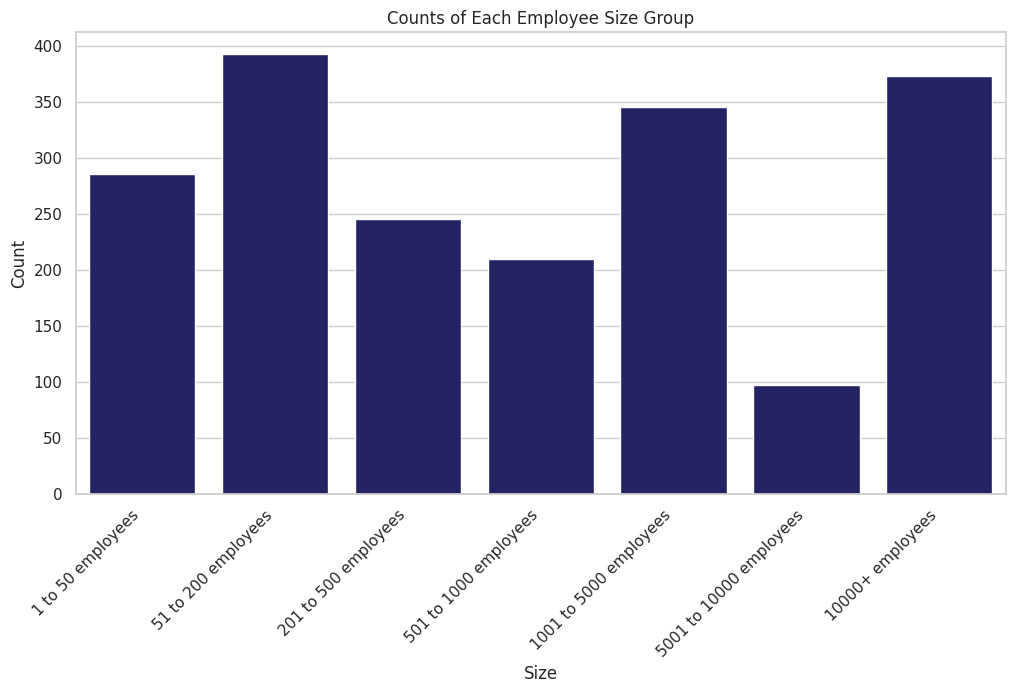

In [36]:
size_counts = size_data_rating['Size'].value_counts()

# Define the custom order for the size categories
size_order = [
    '1 to 50 employees',
    '51 to 200 employees',
    '201 to 500 employees',
    '501 to 1000 employees',
    '1001 to 5000 employees',
    '5001 to 10000 employees',
    '10000+ employees'
]

# Ensure the index is ordered correctly
size_counts = size_counts.reindex(size_order).fillna(0)  # Fill missing values with 0

# Plot the counts
plt.figure(figsize=(12, 6))
sb.barplot(x=size_counts.index, y=size_counts, color='midnightblue')
plt.title('Counts of Each Employee Size Group')
plt.xlabel('Size')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

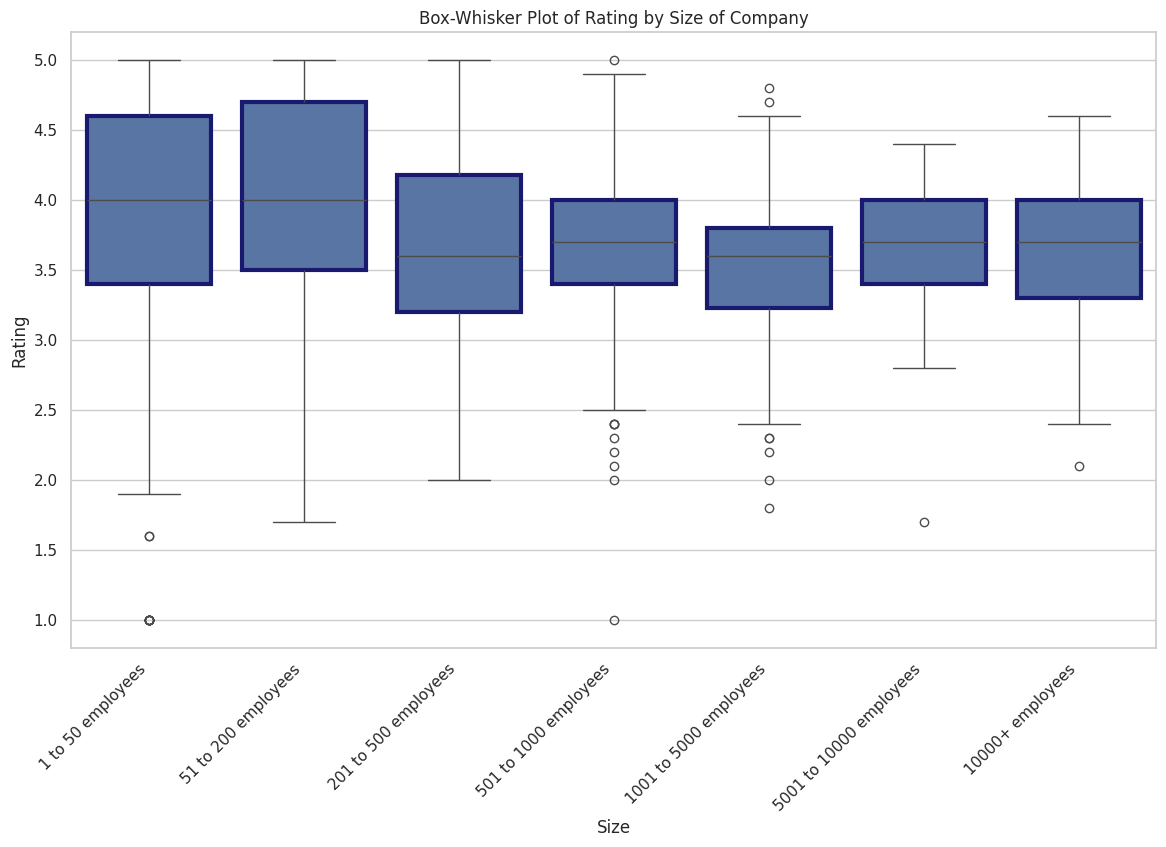

In [37]:
plt.figure(figsize=(14, 8))
sb.boxplot(x='Size', y='Rating', data=size_data_rating,
           order=size_order,
           boxprops=dict(edgecolor='midnightblue', linewidth=3))
plt.xticks(rotation=45, ha='right')
plt.title('Box-Whisker Plot of Rating by Size of Company')
plt.xlabel('Size')
plt.ylabel('Rating')
plt.show()

There is no evidence to suggest a strong relationship between number of employees and average salary. However, the size of the company does seem to have an affect on the rating.

# Year Founded

The following cell looks at the "Founded" column in relation to salary expectations and ratings.

In [38]:
data['Founded'].unique()

array([1961, 1893, 2003, 2002, 2009, 2014, 2001, 1914, 1896, 2013, 1841,
         -1, 1884, 2004, 2016, 1996, 1958, 2006, 1998, 1969, 2011, 2017,
       2005, 1904, 2018, 1956, 2007, 1990, 1923, 2015, 1951, 1981, 2000,
       1966, 1939, 1999, 1812, 1945, 1985, 1984, 1962, 1995, 2012, 1967,
       1799, 1918, 1948, 1994, 1895, 1845, 1968, 2008, 1911, 1997, 1832,
       1934, 1938, 1963, 1992, 1977, 1886, 1862, 1906, 1993, 1935, 1971,
       1989, 1859, 1946, 1818, 1932, 1784, 1856, 1978, 1912, 1957, 1937,
       1982, 1964, 1850, 1983, 1869, 1947, 1868, 1936, 1853, 2010, 1902,
       1944, 1888, 1880, 1973, 1931, 1987, 2019, 1919, 1979, 1954, 1980,
       1976, 1872, 1926, 1991, 1855, 1959, 1986, 1890, 1882, 1883, 1837,
       1817, 1908, 1988, 1965, 1828, 1889, 1898, 1928, 1913, 1901, 1916,
       1857, 1955, 1949, 1970, 1822, 1972, 1864, 1975, 1960, 1885, 1922,
       1740, 1830, 1887, 1974, 1905, 1953, 1952, 1897, 1865, 1921, 1867,
       1933, 1874, 1891, 1807, 1870, 1892, 1852, 16

In [39]:

def bin_founded(year):
    return (year // 25) * 25

data_founded = data[data['Founded'] != -1].copy()
data_founded['Founded_Group'] = data['Founded'].apply(bin_founded)
data_founded = data_founded[['Founded_Group', 'Average_Salary', 'Rating']]
data_founded


,Founded_Group,Average_Salary,Rating
0,1950,51.5,3.2
1,1875,51.5,3.8
2,2000,51.5,3.4
3,2000,51.5,4.1
4,2000,51.5,3.9
...,...,...,...
2243,1925,91.0,3.0
2245,2000,91.0,2.8
2249,1925,91.0,2.9
2251,1975,91.0,3.1


In [40]:
model_salary = ols('Average_Salary ~ C(Founded_Group)', data=data_founded).fit()
anova_salary = sm.stats.anova_lm(model_salary, typ=2)
# Output the ANOVA results
print("ANOVA for Average Salary by Founded Group")
print(anova_salary)

# Perform one-way ANOVA on 'Rating' by 'Length_Group'
data_founded_rating = data_founded[data_founded['Rating'] != -1.0].copy()
model_rating = ols('Rating ~ C(Founded_Group)', data=data_founded_rating).fit()
anova_rating = sm.stats.anova_lm(model_rating, typ=2)
print("\nANOVA for Rating by Founded Group")
print(anova_rating)

ANOVA for Average Salary by Founded Group
                         sum_sq      df         F    PR(>F)
C(Founded_Group)   15131.337386    11.0  2.417041  0.005578
Residual          894649.917664  1572.0       NaN       NaN

ANOVA for Rating by Founded Group
                      sum_sq      df          F        PR(>F)
C(Founded_Group)   61.774206    11.0  17.288312  1.071307e-32
Residual          504.142846  1552.0        NaN           NaN


There does not seem to be a correlation between year founded and salary expectation. However, the ANOVA test for rating would suggest that the year a  company was founded may influence its rating. The following cell plots the average rating for companies.

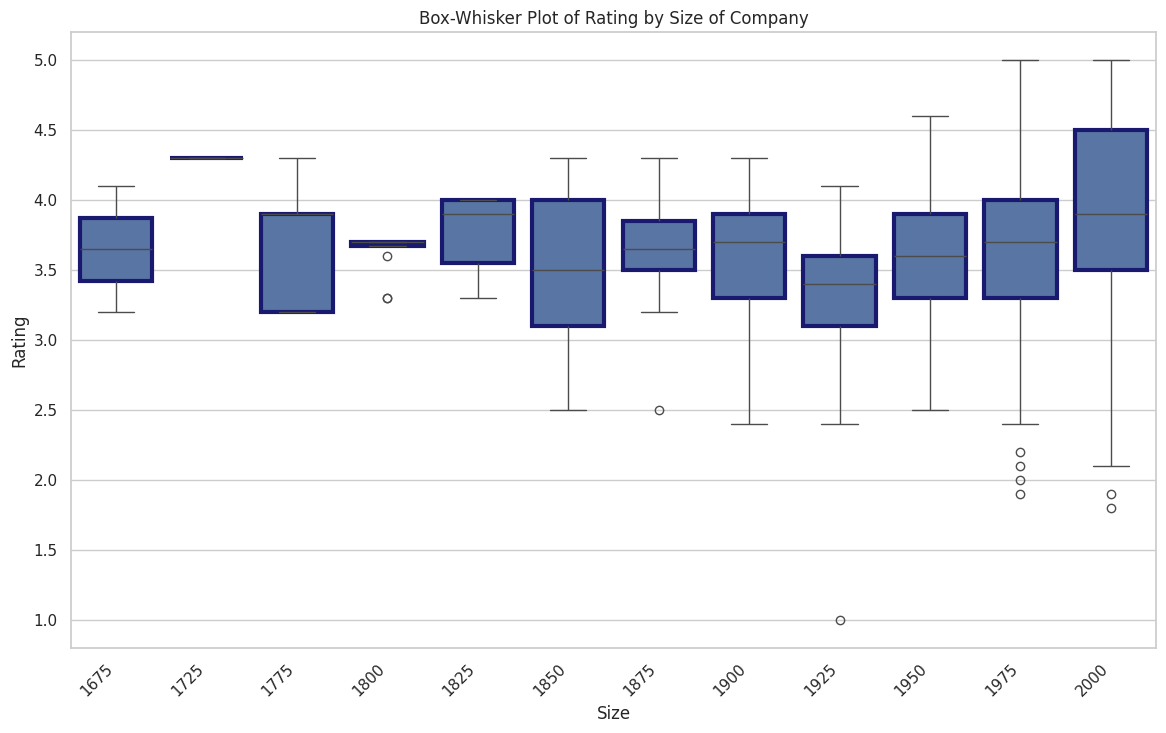

In [41]:

plt.figure(figsize=(14, 8))
sb.boxplot(x='Founded_Group', y='Rating', data=data_founded_rating,
           boxprops=dict(edgecolor='midnightblue', linewidth=3))
plt.xticks(rotation=45, ha='right')
plt.title('Box-Whisker Plot of Rating by Size of Company')
plt.xlabel('Size')
plt.ylabel('Rating')
plt.show()

There is no evidence to suggest a strong relationship between the year a company was founded and average rating. While the ANOVA test suggested a significant difference in the means, the differences do not seem to suggest any trend. There is no clear decrease or increase in rating as years pass. Therefore, the year a company was founded will not be included as an important feature when predicting ratings.

# Ownership Type

The following cell looks at type of ownership.

In [42]:
data['Type of ownership'].unique()

array(['Nonprofit Organization', 'Company - Private',
       'Subsidiary or Business Segment', 'Company - Public', 'Hospital',
       'Unknown', 'Contract', '-1', 'Government',
       'School / School District', 'Other Organization',
       'College / University', 'Self-employed', 'Private Practice / Firm',
       'Franchise'], dtype=object)

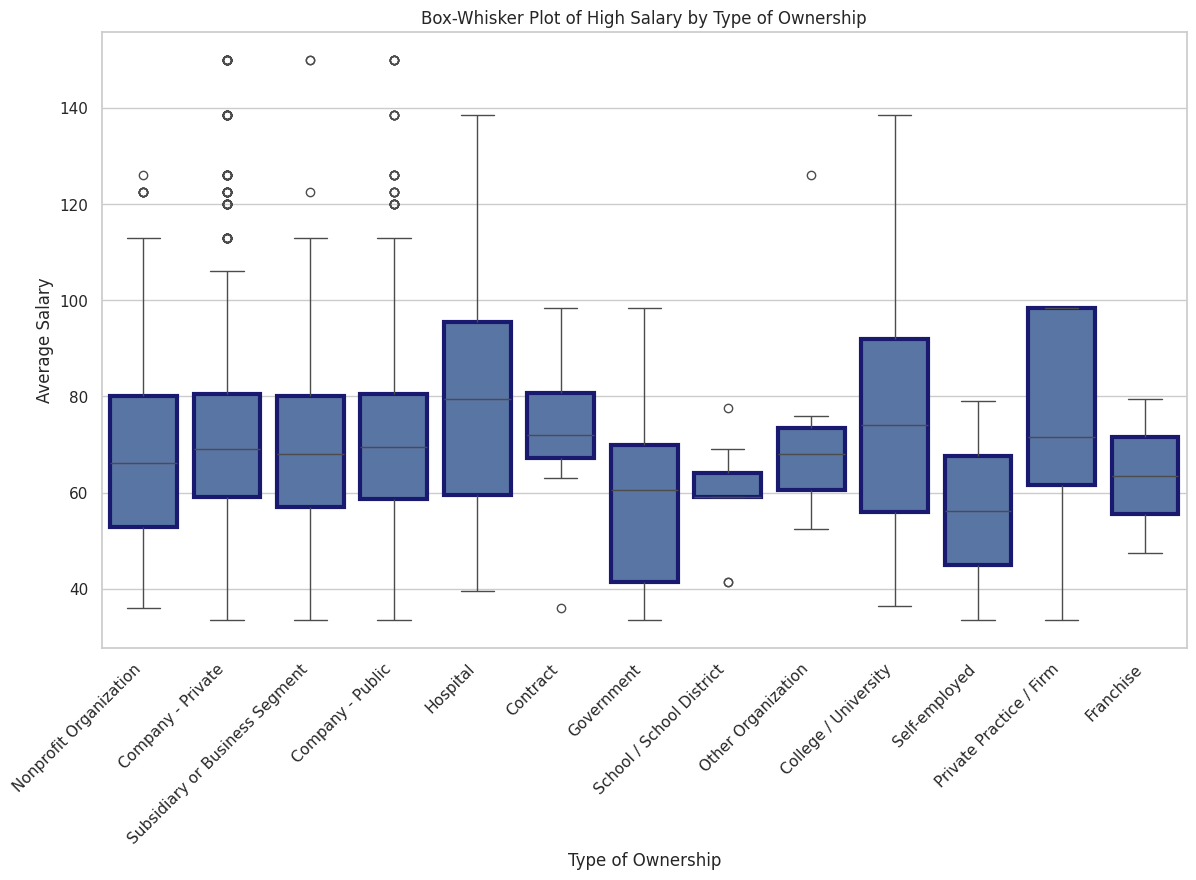

In [43]:
# Create a box-whisker plot for 'Type of ownership' based on average 'High_Salary'
data_ownership = data[~data['Type of ownership'].isin(['-1', 'Unknown'])]
plt.figure(figsize=(14, 8))
sb.boxplot(x='Type of ownership', y='Average_Salary', data=data_ownership,
           boxprops=dict(edgecolor='midnightblue', linewidth=3))
plt.xticks(rotation=45, ha='right')
plt.title('Box-Whisker Plot of High Salary by Type of Ownership')
plt.xlabel('Type of Ownership')
plt.ylabel('Average Salary')
plt.show()

The charts above suggest some ownerships types may have some affect on salary.


In [44]:
ownership_data = data_ownership[['Type of ownership','Average_Salary', 'Rating']]
ownership_data

,Type of ownership,Average_Salary,Rating
0,Nonprofit Organization,51.5,3.2
1,Nonprofit Organization,51.5,3.8
2,Company - Private,51.5,3.4
3,Subsidiary or Business Segment,51.5,4.1
4,Company - Private,51.5,3.9
...,...,...,...
2247,Company - Private,91.0,4.1
2248,Company - Private,91.0,2.5
2249,Company - Public,91.0,2.9
2251,Company - Private,91.0,3.1


The following cell runs one-way ANOVA tests for both salary and ratings compare to type of ownership. The results suggest that the type of ownership of a company affects both expected salary and rating.

In [45]:
# Rename the column without spaces
ownership_data = ownership_data.rename(columns={'Type of ownership': 'Type_of_ownership'})
model_salary = ols('Average_Salary ~ C(Type_of_ownership)', data=ownership_data).fit()
anova_salary = sm.stats.anova_lm(model_salary, typ=2)
print("ANOVA for Average Salary by Type of ownership")
print(anova_salary)

# Perform one-way ANOVA on 'Rating' by 'Length_Group'
ownership_data_rating = ownership_data[ownership_data['Rating'] != -1.0].copy()
model_rating = ols('Rating ~ C(Type_of_ownership)', data=ownership_data_rating).fit()
anova_rating = sm.stats.anova_lm(model_rating, typ=2)
print("\nANOVA for Rating by Type of ownership")
print(anova_rating)


ANOVA for Average Salary by Type of ownership
                            sum_sq      df         F   PR(>F)
C(Type_of_ownership)  1.142999e+04    12.0  1.705481  0.05965
Residual              1.145469e+06  2051.0       NaN      NaN

ANOVA for Rating by Type of ownership
                          sum_sq      df          F        PR(>F)
C(Type_of_ownership)   51.416380    12.0  10.149639  1.264496e-19
Residual              821.931456  1947.0        NaN           NaN


# Industry

The following cell looks into the different industries.

In [46]:
data['Industry'].head(15).unique()


array(['Social Assistance', 'Health Care Services & Hospitals',
       'Internet', 'IT Services', 'Sports & Recreation',
       'Investment Banking & Asset Management', 'Insurance Carriers',
       'Venture Capital & Private Equity', 'Research & Development', '-1',
       'Advertising & Marketing', 'Brokerage Services'], dtype=object)

In [47]:
len(data['Industry'].unique())

89

Since, the 'industry' column contains 89 unique industries, it is necessary to group companies into more general groupings. The 'Sector' column is a more general representation.

# Sector

The following cell looks at sector.

In [48]:
data['Sector'].unique()

array(['Non-Profit', 'Health Care', 'Information Technology',
       'Arts, Entertainment & Recreation', 'Finance', 'Insurance',
       'Business Services', '-1', 'Restaurants, Bars & Food Services',
       'Media', 'Accounting & Legal', 'Real Estate', 'Government',
       'Retail', 'Consumer Services', 'Biotech & Pharmaceuticals',
       'Education', 'Construction, Repair & Maintenance',
       'Oil, Gas, Energy & Utilities', 'Manufacturing',
       'Aerospace & Defense', 'Telecommunications',
       'Transportation & Logistics', 'Mining & Metals',
       'Travel & Tourism'], dtype=object)

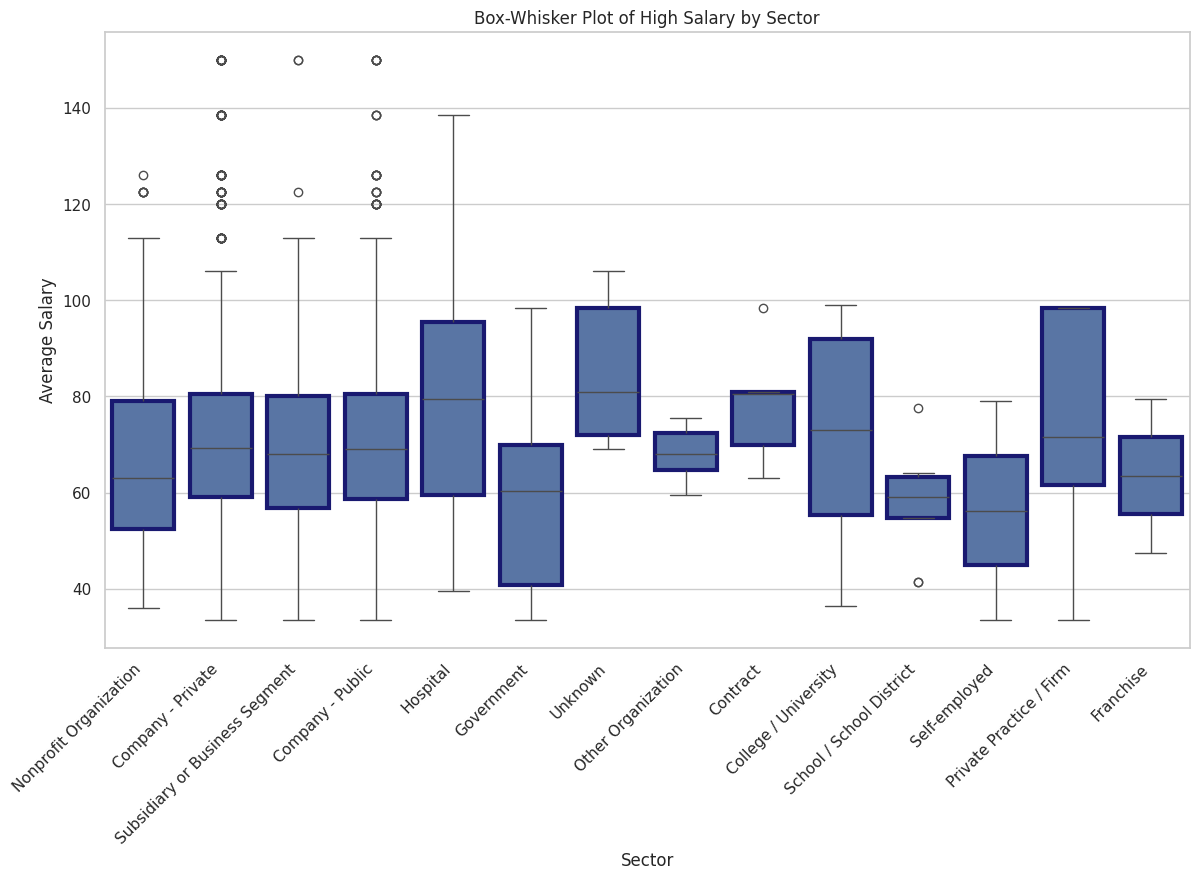

In [49]:
data_sector = data[data['Sector'] != '-1']
plt.figure(figsize=(14, 8))
sb.boxplot(x='Type of ownership', y='Average_Salary', data=data_sector,
           boxprops=dict(edgecolor='midnightblue', linewidth=3))
plt.xticks(rotation=45, ha='right')
plt.title('Box-Whisker Plot of High Salary by Sector')
plt.xlabel('Sector')
plt.ylabel('Average Salary')
plt.show()


In [50]:
data_sector = data_sector[['Sector','Average_Salary', 'Rating']]
data_sector

,Sector,Average_Salary,Rating
0,Non-Profit,51.5,3.2
1,Health Care,51.5,3.8
2,Information Technology,51.5,3.4
3,Information Technology,51.5,4.1
4,"Arts, Entertainment & Recreation",51.5,3.9
...,...,...,...
2247,Information Technology,91.0,4.1
2248,Business Services,91.0,2.5
2249,Business Services,91.0,2.9
2251,Information Technology,91.0,3.1


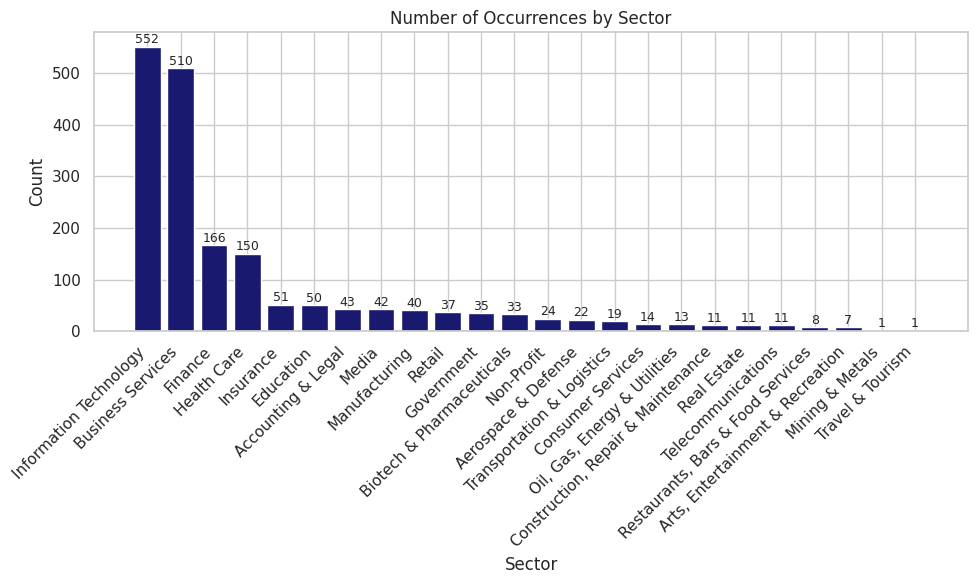

In [51]:
data_sector_rating = data_sector[data_sector['Rating'] != -1.0].copy()
sector_counts = data_sector_rating['Sector'].value_counts().reset_index()
sector_counts.columns = ['Sector', 'Count']
sector_counts = sector_counts.sort_values(by='Count', ascending=False)
plt.figure(figsize=(10, 6))
bars = plt.bar(sector_counts['Sector'], sector_counts['Count'], color='midnightblue')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.title('Number of Occurrences by Sector')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

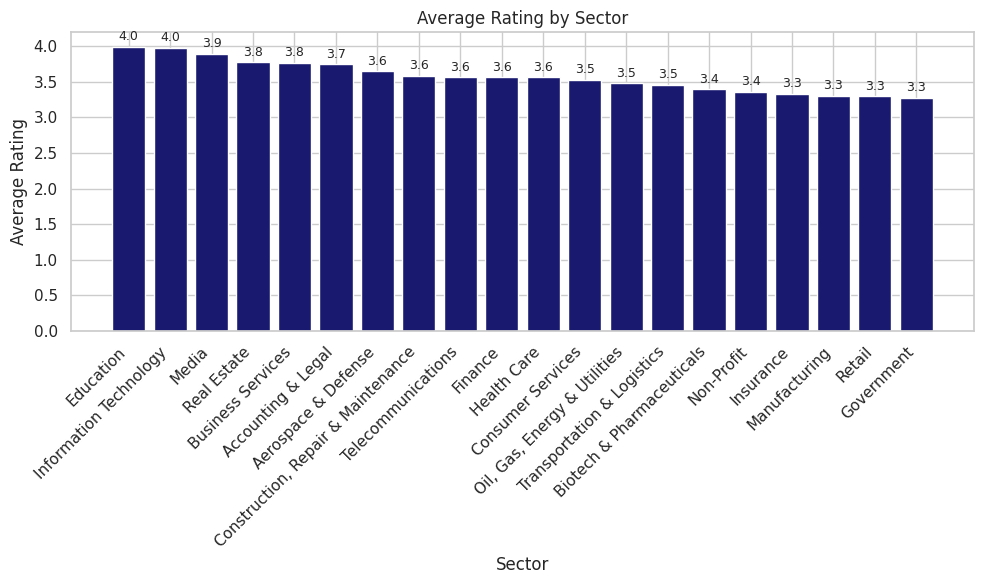

In [52]:
data_sector_rating = data_sector_rating[~data_sector_rating['Sector'].isin(['Travel & Tourism', 'Mining & Metals','Arts, Entertainment & Recreation','Restaurants, Bars & Food Services'])]
avg_rating_by_sector = data_sector_rating.groupby('Sector')['Rating'].mean().reset_index()
avg_rating_by_sector = avg_rating_by_sector.sort_values(by='Rating', ascending=False)
plt.figure(figsize=(10, 6))
bars = plt.bar(avg_rating_by_sector['Sector'], avg_rating_by_sector['Rating'], color='midnightblue')
plt.xlabel('Sector')
plt.ylabel('Average Rating')
plt.title('Average Rating by Sector')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 1), ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The charts above suggest that sector influences salary. In terms of rating, sector has a clear effect on rating.

# Revenue

The following cell looks at revenue.

In [53]:
data['Revenue'].unique()

array(['$100 to $500 million (USD)', '$2 to $5 billion (USD)',
       'Unknown / Non-Applicable', '$50 to $100 million (USD)',
       '$1 to $2 billion (USD)', '$5 to $10 billion (USD)',
       '$1 to $5 million (USD)', '$25 to $50 million (USD)',
       '$10+ billion (USD)', 'Less than $1 million (USD)',
       '$10 to $25 million (USD)', '-1',
       '$500 million to $1 billion (USD)', '$5 to $10 million (USD)'],
      dtype=object)

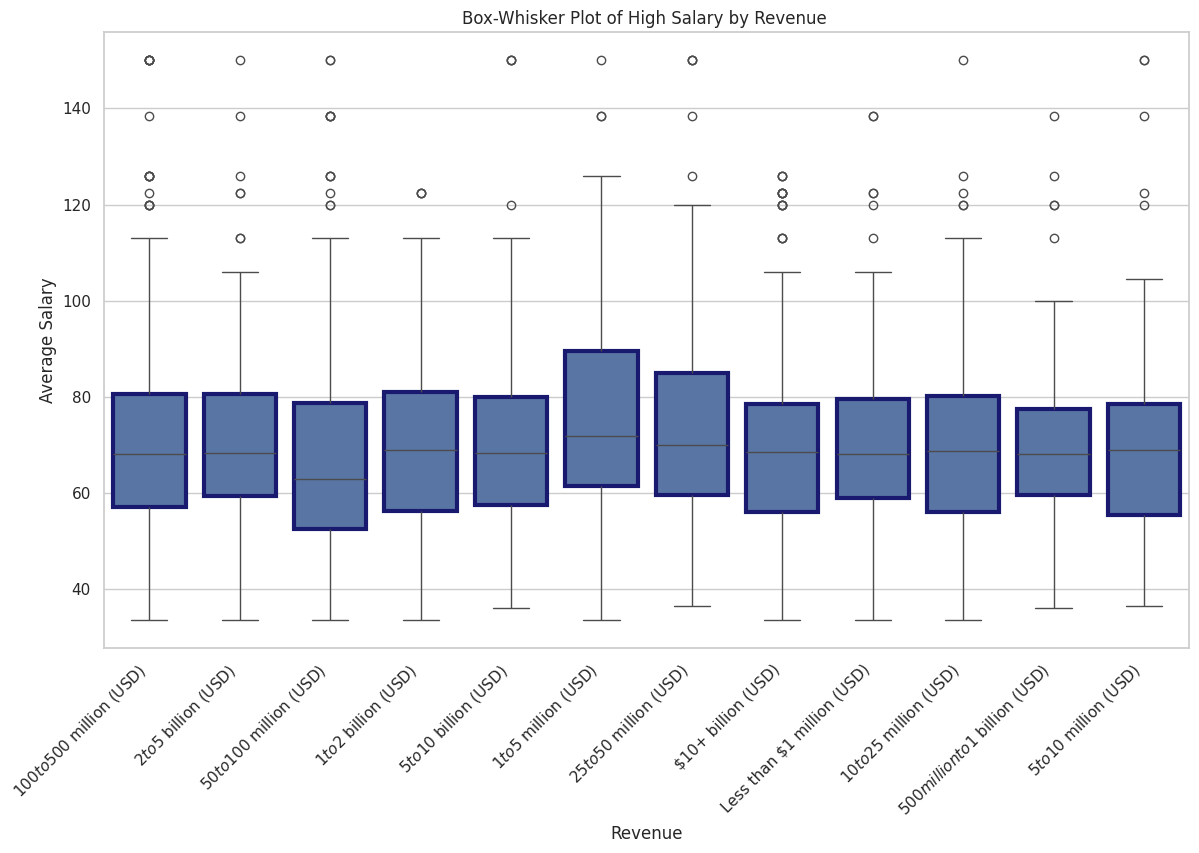

In [54]:
data_revenue = data[~data['Revenue'].isin(['-1', 'Unknown / Non-Applicable'])]
plt.figure(figsize=(14, 8))
sb.boxplot(x='Revenue', y='Average_Salary', data=data_revenue,
           boxprops=dict(edgecolor='midnightblue', linewidth=3))
plt.xticks(rotation=45, ha='right')
plt.title('Box-Whisker Plot of High Salary by Revenue ')
plt.xlabel('Revenue')
plt.ylabel('Average Salary')
plt.show()

The charts above suggest no evidence to suggest that companies with different revenue levels offer different salaries.  

# Competitors

The following cell looks at competitors

In [55]:
data['Competitors_Count'] = data['Competitors'].apply(lambda x: 0 if x == '-1' else x.count(',') + 1)
data['Competitors'] = data['Competitors'].replace('-1', np.nan)
data[['Competitors', 'Competitors_Count']].head(15)

,Competitors,Competitors_Count
0,NaN,0
1,NaN,0
2,GoDaddy,1
3,NaN,0
4,DraftKings,1
5,NaN,0
6,NaN,0
7,"Travelers, Chubb, Crum & Forster",3
8,"Thomson Reuters, Hearst, Pearson",3
9,"Signifyd, Forter",2


In [56]:
competitor_data = data.groupby('Competitors_Count').agg({'Competitors_Count': 'count', 'High_Salary': 'mean', 'Low_Salary': 'mean', 'Rating':'mean'})
competitor_data.columns = ['Count', 'Average High Salary', 'Average Low Salary','Average Rating']
competitor_data

,Count,Average High Salary,Average Low Salary,Average Rating
Competitors_Count,,,,
0,1721,89.900639,54.227193,3.008367
1,34,98.588235,58.647059,3.473529
2,124,91.911290,56.524194,3.584677
3,361,89.559557,53.731302,3.710803
4,1,61.000000,34.000000,3.500000


Since many of the companies in this dataset don't have recorded competitors, it can be ignored. All companies in real life have competitors.

# Easy Apply

The following code cell looks at Easy Apply.

In [57]:
easy_apply_data = data.groupby('Easy Apply').agg({'Easy Apply': 'count', 'Average_Salary': 'mean', 'Rating':'mean'})
easy_apply_data.columns = ['Count', 'Average Salary', 'Average Rating']
easy_apply_data

,Count,Average Salary,Average Rating
Easy Apply,,,
-1,2161,72.02360,3.137066
True,80,77.08125,3.798750


From a contextual point of view, the method of applying to a job would not be indicative of expected salary or employee ratings.

# Final Dataset for models

From the analysis above, three features ('Location_State', 'Type of ownership', and 'Sector') appear to significantly influence salary. In terms of rating, four features ('Location_State', 'Type of ownership', 'Sector', and 'Size') seem to be influential. The following cells create two final dataframes that will be used to run linear regression models to predict the salary and rating of unseen job postings.

In [58]:
pd.set_option('display.max_colwidth', 50)

In [59]:
final_data_salary = data[['Location_State', 'Type of ownership','Sector','Average_Salary']]
columns_to_check = final_data_salary.columns
final_data = final_data_salary[~final_data_salary[columns_to_check].isin(['-1', 'Unknown',-1.0,-1,-1.]).any(axis=1)]

In [60]:
final_data_salary.head()

,Location_State,Type of ownership,Sector,Average_Salary
0,ny,Nonprofit Organization,Non-Profit,51.5
1,ny,Nonprofit Organization,Health Care,51.5
2,ny,Company - Private,Information Technology,51.5
3,ny,Subsidiary or Business Segment,Information Technology,51.5
4,ny,Company - Private,"Arts, Entertainment & Recreation",51.5


In [61]:
final_data_rating = data[['Location_State', 'Type of ownership','Sector','Rating', 'Size']]
columns_to_check = final_data_salary.columns
final_data = final_data_salary[~final_data_salary[columns_to_check].isin(['-1', 'Unknown', -1.0, -1., -1]).any(axis=1)]

# Linear Regression for Salary

In [62]:
final_data_salary = final_data_salary.dropna(subset=['Average_Salary'])
final_data_encoded = pd.get_dummies(final_data_salary, columns=['Location_State', 'Type of ownership', 'Sector'], drop_first=True)
bool_cols = final_data_encoded.select_dtypes(include='bool').columns
final_data_encoded[bool_cols] = final_data_encoded[bool_cols].astype(int)
final_data_encoded = final_data_encoded.apply(pd.to_numeric, errors='coerce')
final_data_encoded.dropna(inplace=True)
X = final_data_encoded.drop('Average_Salary', axis=1)
y = final_data_encoded['Average_Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     14.30
Date:                Wed, 26 Jun 2024   Prob (F-statistic):          3.13e-101
Time:                        17:29:43   Log-Likelihood:                -7880.8
No. Observations:                1792   AIC:                         1.587e+04
Df Residuals:                    1738   BIC:                         1.617e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

The linear regression model above has an R-squared value of 0.308 and an adjusted R-squared value of 0.284. This indicates that the model accounts for about a third of the variance in the response variable (Average_Salary). In conclusion, location, ownership type, and sector all influence salary expectations. As I continue with my job search, I should focus more on these attributes to maximize the chances of securing a high-paying job.

# Linear Regression for Rating

In [63]:
final_data_rating = final_data_rating.dropna(subset=['Rating'])
final_data_encoded = pd.get_dummies(final_data_rating, columns=['Location_State', 'Type of ownership', 'Sector', 'Size'], drop_first=True)
bool_cols = final_data_encoded.select_dtypes(include='bool').columns
final_data_encoded[bool_cols] = final_data_encoded[bool_cols].astype(int)
final_data_encoded = final_data_encoded.apply(pd.to_numeric, errors='coerce')
final_data_encoded.dropna(inplace=True)
X = final_data_encoded.drop('Rating', axis=1)
y = final_data_encoded['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     47.25
Date:                Wed, 26 Jun 2024   Prob (F-statistic):          7.55e-317
Time:                        17:29:43   Log-Likelihood:                -2573.1
No. Observations:                1792   AIC:                             5268.
Df Residuals:                    1731   BIC:                             5603.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

The linear regression model above has an R-squared value of 0.621 and an adjusted R-squared value of 0.608. This indicates that the model accounts for about a two thirds of the variance in the response variable (Rating). In conclusion, location, ownership type, size and sector all influence employee ratings. As I continue with my job search, I should focus more on these attributes to maximize the chances of working in company with a good working environment.